In [ ]:
!nvidia-smi

### Install TensorFlow 

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
!pip install -q tensorflow==2.3.0

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## Library Import 

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Import Data for each category 

In [ ]:
df2_irony = pd.read_csv("irony_data.csv")   
df2_satire = pd.read_csv("satire_data.csv")
df2_understatement = pd.read_csv("understatement_data.csv")
df2_rhetorical_question = pd.read_csv("rhetorical_question_data.csv")
df2_overstatement = pd.read_csv("overstatement_data.csv")

df2_irony =df2_irony.drop(["Unnamed: 0"],axis=1)
df2_satire =df2_satire.drop(["Unnamed: 0"],axis=1)
df2_understatement =df2_understatement.drop(["Unnamed: 0"],axis=1)
df2_rhetorical_question =df2_rhetorical_question.drop(["Unnamed: 0"],axis=1)
df2_overstatement =df2_overstatement.drop(["Unnamed: 0"],axis=1)


In [ ]:
df2_overstatement

,tweet,overstatement
0,over 90 % of adulthood ale is consumed just re...,1
1,another 90 % amount of adulthood intake is jus...,1
2,90 % percent of adulthood consumers is just en...,1
3,he heard a rumor happen that a baja vista blas...,1
4,heard a common rumor that baja energy blast is...,1
...,...,...
115,if you just don't feel like lemonade pie you'm...,1
116,maybe if you just don't like lemonade soup you...,1
117,i ’ ″ m already dying,1
118,when i really ’ m dying,1


In [ ]:
df30 = pd.read_csv("train.En.csv")

df30_irony= df30[["tweet","irony"]]
df30_irony = df30_irony[0:867]

df30_satire= df30[["tweet","satire"]]
df30_satire = df30_satire[0:867]

df30_understatement= df30[["tweet","understatement"]]
df30_understatement = df30_understatement[0:867]

df30_rhetorical_question= df30[["tweet","rhetorical_question"]]
df30_rhetorical_question = df30_rhetorical_question[0:867]

df30_overstatement= df30[["tweet","overstatement"]]
df30_overstatement = df30_overstatement[0:867]

In [ ]:
df30_overstatement

,tweet,overstatement
0,The only thing I got from college is a caffein...,0.0
1,I love it when professors draw a big question ...,0.0
2,Remember the hundred emails from companies whe...,0.0
3,Today my pop-pop told me I was not “forced” to...,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,0.0
...,...,...
862,yo @claires do yall do hysterectomies?,0.0
863,@JacobWohlReport Do I need to aquire a wife be...,0.0
864,I get a lot of boy who cried wolf vibes from t...,0.0
865,Update: holding hands with your mom and walkin...,0.0


In [ ]:
df_irony=df2_irony.append(df30_irony)
df_irony =df_irony.drop_duplicates(subset=['tweet'])
df_irony = df_irony.astype({"irony":int}) 

df_satire=df2_satire.append(df30_satire)
df_satire =df_satire.drop_duplicates(subset=['tweet'])
df_satire = df_satire.astype({"satire":int}) 

df_understatement=df2_understatement.append(df30_understatement)
df_understatement =df_understatement.drop_duplicates(subset=['tweet'])
df_understatement = df_understatement.astype({"understatement":int}) 

df_rhetorical_question=df2_rhetorical_question.append(df30_rhetorical_question)
df_rhetorical_question =df_rhetorical_question.drop_duplicates(subset=['tweet'])
df_rhetorical_question = df_rhetorical_question.astype({"rhetorical_question":int}) 

df_overstatement=df2_overstatement.append(df30_overstatement)
df_overstatement =df_overstatement.drop_duplicates(subset=['tweet'])
df_overstatement = df_overstatement.astype({"overstatement":int}) 

In [ ]:
df_overstatement

,tweet,overstatement
0,over 90 % of adulthood ale is consumed just re...,1
1,another 90 % amount of adulthood intake is jus...,1
2,90 % percent of adulthood consumers is just en...,1
3,he heard a rumor happen that a baja vista blas...,1
4,heard a common rumor that baja energy blast is...,1
...,...,...
862,yo @claires do yall do hysterectomies?,0
863,@JacobWohlReport Do I need to aquire a wife be...,0
864,I get a lot of boy who cried wolf vibes from t...,0
865,Update: holding hands with your mom and walkin...,0


## Data Cleaning

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import string
exclude = set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
b = list(df_irony["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub('\[[^]]*\]', ' ', review)
    review = review.lower()
    corpus.append(review)
df_irony = df_irony.assign(clean_tweet2 = corpus)

b = list(df_satire["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub('\[[^]]*\]', ' ', review)
    review = review.lower()
    corpus.append(review)
df_satire = df_satire.assign(clean_tweet2 = corpus)

b = list(df_understatement["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub('\[[^]]*\]', ' ', review)
    review = review.lower()
    corpus.append(review)
df_understatement = df_understatement.assign(clean_tweet2 = corpus)

b = list(df_rhetorical_question["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub('\[[^]]*\]', ' ', review)
    review = review.lower()
    corpus.append(review)
df_rhetorical_question = df_rhetorical_question.assign(clean_tweet2 = corpus)

b = list(df_overstatement["tweet"])
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub('\[[^]]*\]', ' ', review)
    review = review.lower()
    corpus.append(review)
df_overstatement = df_overstatement.assign(clean_tweet2 = corpus)

In [ ]:
df3_irony = df_irony[["clean_tweet2","irony"]]

df3_satire = df_satire[["clean_tweet2","satire"]]

df3_understatement = df_understatement[["clean_tweet2","understatement"]]

df3_rhetorical_question = df_rhetorical_question[["clean_tweet2","rhetorical_question"]]

df3_overstatement = df_overstatement[["clean_tweet2","overstatement"]]



In [ ]:
df3_irony

,clean_tweet2,irony
0,the only favorite thing ever i got from junior...,1
1,the very only lucky thing i got fresh from col...,1
2,like the absolutely only thing i got from coll...,1
3,remember the hundred percent emails from compa...,1
4,remember the hundred emails from companies whe...,1
...,...,...
862,yo do yall do hysterectomies?,0
863,do i need to aquire a wife before this happe...,0
864,i get a lot of boy who cried wolf vibes from t...,1
865,update: holding hands with your mom and walkin...,0


In [ ]:
df3_irony["irony"].value_counts()

0    712
1    620
Name: irony, dtype: int64

## Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_irony_df, remaining1 = train_test_split(df3_irony, random_state= 42, train_size= 0.75, stratify=df3_irony.irony.values) 
test_irony_df, valid_irony_df = train_test_split(remaining1 , random_state= 42, train_size= 0.60, stratify=remaining1.irony.values)

train_satire_df, remaining2 = train_test_split(df3_satire, random_state= 42, train_size= 0.75, stratify=df3_satire.satire.values) 
test_satire_df, valid_satire_df = train_test_split(remaining2 , random_state= 42, train_size= 0.60, stratify=remaining2.satire.values)

train_understatement_df, remaining3 = train_test_split(df3_understatement, random_state= 42, train_size= 0.75, stratify=df3_understatement.understatement.values) 
test_understatement_df, valid_understatement_df = train_test_split(remaining3 , random_state= 42, train_size= 0.60, stratify=remaining3.understatement.values)

train_rhetorical_question_df, remaining4 = train_test_split(df3_rhetorical_question, random_state= 42, train_size= 0.75, stratify=df3_rhetorical_question.rhetorical_question.values) 
test_rhetorical_question_df, valid_rhetorical_question_df = train_test_split(remaining4 , random_state= 42, train_size= 0.60, stratify=remaining4.rhetorical_question.values)

train_overstatement_df, remaining5 = train_test_split(df3_overstatement, random_state= 42, train_size= 0.75, stratify=df3_overstatement.overstatement.values) 
test_overstatement_df, valid_overstatement_df = train_test_split(remaining5 , random_state= 42, train_size= 0.60, stratify=remaining5.overstatement.values)


In [ ]:
with tf.device('/cpu:0'):
  train_irony_data = tf.data.Dataset.from_tensor_slices((train_irony_df['clean_tweet2'].values, train_irony_df['irony'].values))
  valid_irony_data = tf.data.Dataset.from_tensor_slices((valid_irony_df.clean_tweet2.values, valid_irony_df.irony.values))

  train_satire_data = tf.data.Dataset.from_tensor_slices((train_satire_df['clean_tweet2'].values, train_satire_df['satire'].values))
  valid_satire_data = tf.data.Dataset.from_tensor_slices((valid_satire_df.clean_tweet2.values, valid_satire_df.satire.values))

  train_understatement_data = tf.data.Dataset.from_tensor_slices((train_understatement_df['clean_tweet2'].values, train_understatement_df['understatement'].values))
  valid_understatement_data = tf.data.Dataset.from_tensor_slices((valid_understatement_df.clean_tweet2.values, valid_understatement_df.understatement.values))

  train_rhetorical_question_data = tf.data.Dataset.from_tensor_slices((train_rhetorical_question_df['clean_tweet2'].values, train_rhetorical_question_df['rhetorical_question'].values))
  valid_rhetorical_question_data = tf.data.Dataset.from_tensor_slices((valid_rhetorical_question_df.clean_tweet2.values, valid_rhetorical_question_df.rhetorical_question.values))


  train_overstatement_data = tf.data.Dataset.from_tensor_slices((train_overstatement_df['clean_tweet2'].values, train_overstatement_df['overstatement'].values))
  valid_overstatement_data = tf.data.Dataset.from_tensor_slices((valid_overstatement_df.clean_tweet2.values, valid_overstatement_df.overstatement.values))

  
  for text, label in train_irony_data.take(1):
    print(text)
    print(label)
  for text, label in train_satire_data.take(1):
    print(text)
    print(label)
  for text, label in train_understatement_data.take(1):
    print(text)
    print(label)
  for text, label in train_rhetorical_question_data.take(1):
    print(text)
    print(label)
  for text, label in train_overstatement_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'oh you\xe2\x80\x99re just friends?\r\n\r\nwhy\xe2\x80\x99d u shave then?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"@ inkofreality @ the strangertings1 @ nytimes 1 you're so goddamn close back to their understanding using baseline biasing. you never can even get outta there, i believe in being you!", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"gosh sunderland twitter is a fun place to be tonight isn't it. one game. one game!!!", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'its 3 30 am and i have decided the only redeeming quality of a male is that i can put my freezing cold toes on him and leach his warmth', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'going to be running on three hours of sleep at work tonight! so excited!!!', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


##  Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the tweet and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1] #  Label categories
max_seq_length = 120 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case =bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi, Uday what are doing?")  # tokenizer testing

['hi', '##,', '[UNK]', 'what', 'are', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, Uday what are doing?"))

[7632, 29623, 100, 2054, 2024, 2725, 29632]

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy()) # guid gives unqui id but we are working one example at time so its is  and we use text.numpy because text is in tensor so to get value of it we use np
                                             # and we are doing only sentence classification so be but text_b equal to none but if it is next sentence prediction it would be different
  # Now we have to convert this example into features 
  features = classifier_data_lib.convert_single_example(0, example, label_list,max_seq_length, tokenizer) # 0 is the index of first example

  return (features.input_ids, features.input_mask, features.segment_ids, features.label_id) # below text is important plz read carefully 
  

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout =[tf.int32,tf.int32,tf.int32,tf.int32]) # Tout is tensor output
  # but here issue is this function wrapper doesn't set shape of return tensor but we don't need the shape of label tensor. So we will set the shape of this tensor
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([]) # because we don't know that shape of label may be in multiclassification it can be more than 2

  x = {
      "input_word_ids" : input_ids,
       "input_mask" : input_mask,
       "input_type_ids" : segment_ids
  }

  return (x, label_id)
  

##  Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train              
  train_irony_data = (train_irony_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  
  # valid
  valid_irony_data = (valid_irony_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  # train              
  train_satire_data = (train_satire_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  
  # valid
  valid_satire_data = (valid_satire_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  
  # train              
  train_understatement_data = (train_understatement_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  
  # valid
  valid_understatement_data = (valid_understatement_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  
  # train              
  train_rhetorical_question_data = (train_rhetorical_question_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  
  # valid
  valid_rhetorical_question_data = (valid_rhetorical_question_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  
  # train              
  train_overstatement_data = (train_overstatement_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  
  # valid
  valid_overstatement_data = (valid_overstatement_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  

In [ ]:
# train data spec
train_irony_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_irony_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

 ## Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation="sigmoid", name="output")  (drop)

  model = tf.keras.Model(
      inputs= {
          "input_word_ids" : input_word_ids,
          "input_mask" : input_mask,
          "input_type_ids" : input_type_ids
      },
      outputs = output)
  return model

##  Fine-Tune BERT for Text Classification

In [ ]:
model_irony = create_model()
model_satire = create_model()
model_understatement = create_model()
model_rhetorical_question = create_model()
model_overstatement = create_model()

model_irony.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_satire.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_understatement.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_rhetorical_question.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_overstatement.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])



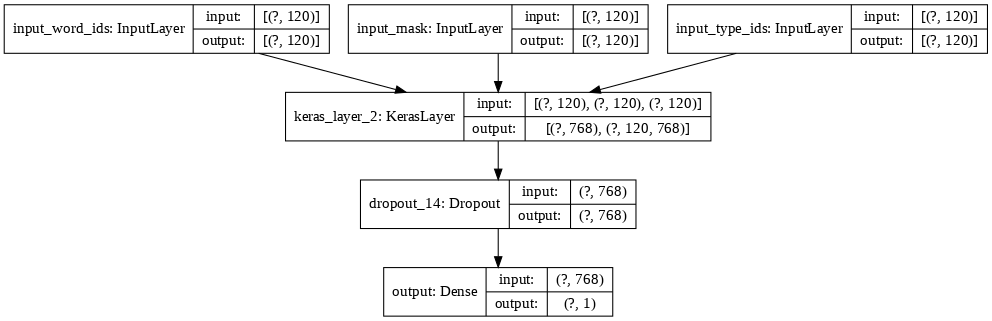

In [ ]:
tf.keras.utils.plot_model(model=model_overstatement, show_shapes=True, dpi = 76) # by default dpi is 96 , result show layer is single layer

In [ ]:
# Train model
epochs = 3 # after 2 this start overfitting
history1 = model_irony.fit(train_irony_data, validation_data=valid_irony_data, epochs=epochs, verbose=1)
history2 = model_satire.fit(train_satire_data, validation_data=valid_satire_data, epochs=epochs, verbose=1)
history3 = model_understatement.fit(train_understatement_data, validation_data=valid_understatement_data, epochs=epochs, verbose=1)
history4 = model_rhetorical_question.fit(train_rhetorical_question_data, validation_data=valid_rhetorical_question_data, epochs=epochs, verbose=1)
history5 = model_overstatement.fit(train_overstatement_data, validation_data=valid_overstatement_data, epochs=epochs, verbose=1)

Epoch 1/3
31/31 [==============================] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9637WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0121s vs `on_test_batch_end` time: 0.1368s). Check your callbacks.


31/31 [==============================] - 14s 463ms/step - loss: 0.0930 - binary_accuracy: 0.9637 - val_loss: 0.4119 - val_binary_accuracy: 0.8828
Epoch 2/3
31/31 [==============================] - 14s 462ms/step - loss: 0.0038 - binary_accuracy: 1.0000 - val_loss: 0.4040 - val_binary_accuracy: 0.9062
Epoch 3/3
31/31 [==============================] - 14s 462ms/step - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 0.3613 - val_binary_accuracy: 0.8906
Epoch 1/3
22/22 [==============================] - ETA: 0s - loss: 0.0244 - binary_accuracy: 0.9957WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_test_batch_end` time: 0.1346s). Check your callbacks.


22/22 [==============================] - 10s 454ms/step - loss: 0.0244 - binary_accuracy: 0.9957 - val_loss: 0.0020 - val_binary_accuracy: 1.0000
Epoch 2/3
22/22 [==============================] - 10s 453ms/step - loss: 0.0032 - binary_accuracy: 1.0000 - val_loss: 0.0026 - val_binary_accuracy: 1.0000
Epoch 3/3
22/22 [==============================] - 10s 453ms/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 0.0016 - val_binary_accuracy: 1.0000
Epoch 1/3
21/21 [==============================] - ETA: 0s - loss: 0.0132 - binary_accuracy: 0.9955WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0099s vs `on_test_batch_end` time: 0.1375s). Check your callbacks.


21/21 [==============================] - 10s 454ms/step - loss: 0.0132 - binary_accuracy: 0.9955 - val_loss: 0.0925 - val_binary_accuracy: 0.9844
Epoch 2/3
21/21 [==============================] - 10s 454ms/step - loss: 0.0030 - binary_accuracy: 1.0000 - val_loss: 0.0973 - val_binary_accuracy: 0.9844
Epoch 3/3
21/21 [==============================] - 10s 454ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - val_loss: 0.1013 - val_binary_accuracy: 0.9844
Epoch 1/3
27/27 [==============================] - ETA: 0s - loss: 0.0274 - binary_accuracy: 0.9988WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0098s vs `on_test_batch_end` time: 0.1371s). Check your callbacks.


27/27 [==============================] - 12s 459ms/step - loss: 0.0274 - binary_accuracy: 0.9988 - val_loss: 0.2451 - val_binary_accuracy: 0.9062
Epoch 2/3
27/27 [==============================] - 12s 459ms/step - loss: 0.0038 - binary_accuracy: 0.9988 - val_loss: 0.2547 - val_binary_accuracy: 0.9167
Epoch 3/3
27/27 [==============================] - 12s 458ms/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 0.2797 - val_binary_accuracy: 0.9271
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 0.0167 - binary_accuracy: 0.9973WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_test_batch_end` time: 0.1371s). Check your callbacks.


23/23 [==============================] - 11s 460ms/step - loss: 0.0167 - binary_accuracy: 0.9973 - val_loss: 0.2866 - val_binary_accuracy: 0.9271
Epoch 2/3
23/23 [==============================] - 11s 459ms/step - loss: 0.0035 - binary_accuracy: 1.0000 - val_loss: 0.3993 - val_binary_accuracy: 0.9375
Epoch 3/3
23/23 [==============================] - 11s 460ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 0.3481 - val_binary_accuracy: 0.9375


## Evaluate the BERT Text Classification Model for each category

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [ ]:
pred_list = test_irony_df.clean_tweet2.values
true_labels = test_irony_df['irony'].tolist()
# sample_example =   ["Why don't Algerian Jews go back to Algeria?","Are Palestinians on Quora anti-Semitic?	","What is Brandy Greene known for?	","Why are you not dying","Schools should be banned, right? ","Where is India in World map?"]
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_irony.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]
print(prediction.count(1))
print(len(prediction))
print(classification_report(true_labels, prediction))
f1_score(true_labels, prediction, average='macro')

83
199
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       106
           1       0.93      0.83      0.87        93

    accuracy                           0.89       199
   macro avg       0.89      0.89      0.89       199
weighted avg       0.89      0.89      0.89       199



0.8879504504504504

In [ ]:
pred_list = test_satire_df.clean_tweet2.values
true_labels = test_satire_df['satire'].tolist()
# sample_example =   ["Why don't Algerian Jews go back to Algeria?","Are Palestinians on Quora anti-Semitic?	","What is Brandy Greene known for?	","Why are you not dying","Schools should be banned, right? ","Where is India in World map?"]
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_satire.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]
print(prediction.count(1))
print(len(prediction))
print(classification_report(true_labels, prediction))
f1_score(true_labels, prediction, average='macro')

13
141
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       126
           1       1.00      0.87      0.93        15

    accuracy                           0.99       141
   macro avg       0.99      0.93      0.96       141
weighted avg       0.99      0.99      0.99       141



0.9603487064116986

In [ ]:
pred_list = test_understatement_df.clean_tweet2.values
true_labels = test_understatement_df['understatement'].tolist()
# sample_example =   ["Why don't Algerian Jews go back to Algeria?","Are Palestinians on Quora anti-Semitic?	","What is Brandy Greene known for?	","Why are you not dying","Schools should be banned, right? ","Where is India in World map?"]
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_understatement.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]
print(prediction.count(1))
print(len(prediction))
print(classification_report(true_labels, prediction))
f1_score(true_labels, prediction, average='macro')

6
135
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00         6

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



1.0

In [ ]:
pred_list = test_rhetorical_question_df.clean_tweet2.values
true_labels = test_rhetorical_question_df['rhetorical_question'].tolist()
# sample_example =   ["Why don't Algerian Jews go back to Algeria?","Are Palestinians on Quora anti-Semitic?	","What is Brandy Greene known for?	","Why are you not dying","Schools should be banned, right? ","Where is India in World map?"]
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_rhetorical_question.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]
print(prediction.count(1))
print(len(prediction))
print(classification_report(true_labels, prediction))
f1_score(true_labels, prediction, average='macro')

62
175
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       115
           1       0.90      0.93      0.92        60

    accuracy                           0.94       175
   macro avg       0.93      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



0.9370865688812194

In [ ]:
pred_list = test_overstatement_df.clean_tweet2.values
true_labels = test_overstatement_df['overstatement'].tolist()
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_overstatement.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]
print(prediction.count(1))
print(len(prediction))
print(classification_report(true_labels, prediction))
f1_score(true_labels, prediction, average='macro')

22
148
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      0.92      0.96        24

    accuracy                           0.99       148
   macro avg       0.99      0.96      0.97       148
weighted avg       0.99      0.99      0.99       148



0.9742608695652173

## Prediction on test data

In [ ]:
pred_data = pd.read_csv("/content/taskB.En.input.csv")
pred_data.head()

,text
0,saw a video of someone getting a hug. would LO...
1,"""This Christmas I hope you all either get vacc..."
2,It's the alamo
3,"Wind 5 mph E. Barometer 1029.8 hPa, Pressure t..."
4,I constantly have loads of the new symptoms bu...


In [ ]:
pred_list2 = pred_data.text.values
pred_list2

array(['saw a video of someone getting a hug. would LOVE a hug. u know those really nice ones',
       '"This Christmas I hope you all either get vaccinated or wear a mask. The omicron variant is not going to give us a nice Christmas gift by deciding to not be spread amongst people." ',
       "It's the alamo", ...,
       'Of course it’s raining when I’m due to go out tonight 👍🏻',
       'Weigh up a lie before you tell it.',
       'Upand dressed at a reasonable time once again now that I have a new bathroom floor down'],
      dtype=object)

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((pred_list2, [0]*len(pred_list2))) 
test_data = (test_data.map(to_feature_map).batch(1))
threshold = 0.5 # between 0 and 1


In [ ]:
preds = model_irony.predict(test_data)
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]
taskb_pred = pd.DataFrame(prediction2, columns =['irony'])
print(prediction2.count(1))
len(prediction2)

250


1400

In [ ]:
preds = model_satire.predict(test_data)
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]
taskb_pred = taskb_pred.assign(satire=prediction2)
print(prediction2.count(1))
len(prediction2)

23


1400

In [ ]:
preds = model_understatement.predict(test_data)
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]
taskb_pred = taskb_pred.assign(understatement=prediction2)
print(prediction2.count(1))
len(prediction2)

24


1400

In [ ]:
preds = model_rhetorical_question.predict(test_data)
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]
taskb_pred = taskb_pred.assign(rhetorical_question=prediction2)
print(prediction2.count(1))
len(prediction2)

134


1400

In [ ]:
preds = model_overstatement.predict(test_data)
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]
taskb_pred = taskb_pred.assign(overstatement=prediction2)
print(prediction2.count(1))
len(prediction2)

36


1400

In [ ]:
taskb_pred.to_csv("taskb_data_aug_on public_data.csv", index = False)

In [ ]:
#########################################################################################

In [ ]:
taskb_pred

,irony,satire,understatement,rhetorical_question,overstatement
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1395,0,0,0,0,0
1396,1,0,0,0,0
1397,1,0,0,0,0
1398,0,0,0,0,0


## Result

Detail Result for irony: Accuracy = 0.89, Macro F1-Score= 0.88,

Detail Result for satire: Accuracy = 0.99, Macro F1-Score= 0.96,

Detail Result for understatement : Accuracy = 1.00, Macro F1-Score= 1.00,

Detail Result for overstatement: Accuracy = .99, Macro F1-Score= 0.97,

Detail Result for rhetorical question: Accuracy = 0.94, Macro F1-Score= 0.93